# Old Babylonian Lists of Trees and Wooden Objects

## Introductory text needs updating
This notebook will use data scraped from [DCCLT](http://oracc.org/dcclt) with the notebooks [Save ORACC HTML files](https://github.com/niekveldhuis/Digital-Assyriology/blob/master/Scrape-Oracc/Save%20Oracc%20HTML%20files.ipynb) and [Scrape Oracc](https://github.com/niekveldhuis/Digital-Assyriology/blob/master/Scrape-Oracc/Scrape%20Oracc.ipynb), using the input file [ob_lists_wood.txt](https://github.com/ErinBecker/digital-humanities-phylogenetics/blob/master/data/text_ids/ob_lists_wood.txt). The input file lists all the Text IDs of Old Babylonian lists of trees and wooden objects currently in DCCLT, as well as the composite text of the Nippur version. Text IDs consist of a P plus a six-digit number (commonly referred to as P-number) that is recognized by [ORACC](http://oracc.org) and by [CDLI](http://cdli.ucla.edu) and that has become the de-facto standard in Assyriology. [CDLI](http://cdli.ucla.edu) provides metadata (provenience, period, publication, museum number, etc) for each text.  Composite text IDs consist of a Q plus a six-digit number.

The raw data are placed in the directory [data/raw](https://github.com/ErinBecker/digital-humanities-phylogenetics/tree/master/data/raw). Each text has a separate file named dcclt_P######.txt (or dcclt_Q######.txt). These are comma-separated files with the fields id_text, text_name, l_no, text. 

| field         | description                     |
|-----------	|------------------------------------------------------------------------------------------------------------------------------------------------------	|
| text_id   	| allows creation of a link to the online edition in [DCCLT](http://oracc.org/dcclt) and/or to the images and metadata in [CDLI](http://cdli.ucla.edu) 	|
| text_name 	| a reference to a text (publication or museum number) that is recognizable by Assyriologists                                                          	|
| l_no      	| line number: obverse/reverse, column number, line number (e.g. o ii 16')                                                                                  	|
| text      	| Sumerian words in lemmatized form (e.g. lugal[king]N)                                                                                                     	|

In [1]:
import pandas as pd
import numpy as np
import re

# Open File
Open file `obwood.csv` and create a Dataframe in Pandas. 

In [25]:
file = '../data/obwood.csv'
df = pd.read_csv(file).drop('Unnamed: 0', axis=1)

In [26]:
df.head()

,id_line,label,base,lemma
0,P117395.2,o 1,{ŋeš}e₃-a,ŋešed[key]N
1,P117395.3,o 2,{ŋeš}pa-kud,pakud[~tree]N
2,P117395.4,o 3,{ŋeš}raba,raba[clamp]N
3,P117404.2,o 1,{ŋeš}ig {ŋeš}eren,ig[door]N eren[cedar]N
4,P117404.3,o 2,{ŋeš}ig dib,ig[door]N dib[board]N


# Create Expressions
A line in a lexical text may contain more than one word. Usually a list is divided into sections by keyword, for instance:

| text                	| translation                      	|
|---------------------	|----------------------------------	|
| {ŋeš}gigir          	| chariot                          	|
| {ŋeš}e₂ gigir       	| chariot cabin                    	|
| {ŋeš}e₂ usan₃ gigir 	| storage box for the chariot whip 	|
| {ŋeš}gaba gigir     	| breastwork of a chariot          	|

In the comparison between different versions of the list the individual words are less interesting than the *entries*, that is: the sequence of words in a single line. In order to look at entries (rather than words), words in an entry are connected by asterisks (\*). Since in this case all words are in Sumerian, the language designation (sux:) is removed from the field `entries`.

In [27]:
df['entries'] = df['lemma']
df['entries'] = df['entries'].str.replace(' ', '_')
df['id_text'] = df['id_line'].str[:7]
df['line'] = [int(re.sub('.+\.', '', line)) for line in df['id_line']] #create a line number for indexing
df.head()

,id_line,label,base,lemma,entries,id_text,line
0,P117395.2,o 1,{ŋeš}e₃-a,ŋešed[key]N,ŋešed[key]N,P117395,2
1,P117395.3,o 2,{ŋeš}pa-kud,pakud[~tree]N,pakud[~tree]N,P117395,3
2,P117395.4,o 3,{ŋeš}raba,raba[clamp]N,raba[clamp]N,P117395,4
3,P117404.2,o 1,{ŋeš}ig {ŋeš}eren,ig[door]N eren[cedar]N,ig[door]N_eren[cedar]N,P117404,2
4,P117404.3,o 2,{ŋeš}ig dib,ig[door]N dib[board]N,ig[door]N_dib[board]N,P117404,3


# Group by Document
The `groupby()` function is used to group the data by document. The function `apply(' '.join)` concatenates the text in the `entries` column, separating them with a white space. The Pandas `groupby()` function results in a series, which is then tranformed into a new Dataframe.

In [32]:
entries_df = df[['id_text', 'line', 'entries']]
#entries_df = entries_df.dropna()
grouped = entries_df['entries'].groupby([entries_df['id_text'], entries_df['line']]).apply(' '.join).reset_index()
by_text_df = pd.DataFrame(grouped)
by_text_df.head()

,id_text,line,entries
0,P117395,2,ŋešed[key]N
1,P117395,3,pakud[~tree]N
2,P117395,4,raba[clamp]N
3,P117404,2,ig[door]N_eren[cedar]N
4,P117404,3,ig[door]N_dib[board]N


# Document Term Matrix
Transform the DataFrame into a Document Term Matrix (DTM) by using CountVecorizer. This function uses a Regular Expression (token_pattern) to indicate how to find the beginning and end of token. In the current Dataframe entries are separated from each other by a white space. The expression `r.[^ ]+` means: any combination of characters, except the space.

The output of the CountVectorizer (`dtm`) is not in a human-readable format. It is transformed into another DataFrame, with `id_text` as index.

In [33]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(analyzer='word', token_pattern=r'[^ ]+')
dtm = cv.fit_transform(by_text_df['entries'])
dtm_df = pd.DataFrame(dtm.toarray(), columns = cv.get_feature_names(), index = by_text_df.index.values)
dtm_df.head()

,1(ban₂)_1(diš)_sila[unit]n_11,1(ban₂)_2(diš)_sila[unit]n_12,1(ban₂)_3(diš)_sila[unit]n_13,1(ban₂)_4(diš)_sila[unit]n_14,1(ban₂)_5(diš)_sila[unit]n_15,1(ban₂)_še[barley]n_10,10_še[barley]n_kugbabbar[silver]n,11_še[barley]n_kugbabbar[silver]n,12_še[barley]n_kugbabbar[silver]n,13_še[barley]n_kugbabbar[silver]n,...,šuʾa[stool]n_ašgab[leatherworker]n,šuʾa[stool]n_burgul[stone-cutter]n,šuʾa[stool]n_dus[bathroom]n,šuʾa[stool]n_kaskal[way]n,šuʾa[stool]n_nagar[carpenter]n,šuʾa[stool]n_niŋgula[greatness]n,šuʾa[stool]n_suhsah[sound]n,šuʾa[stool]n_tibira[sculptor]n,šuʾa[stool]n_x,šuʾura[goose]n
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Analyzing the DTM
There are various ways in which a DTM may be analyzed. Each document may be understood as a vector, which allows for various kinds of computations, such as distance or cosine-similarity. 

It is important to recall that the DTM does not preserve information about the order of entries. In comparing versions of a lexical text we may think of four types of features: 

* presence or absence of entries
* order of entries in a section
* order of sections in the document
* spelling of words

The present DTM can only address the first feature.

It is also important to realize that the documents in this analysis of are of very different length (from 1 to 750 entries), with more than half of the documents 2 lines or less. The composite text from Nippur is by far the longest document and will dominate any comparison

In [34]:
df_length = dtm_df.sum(axis=1)
df_length.describe()

count    4903.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
dtype: float64

Note that I'll be doing some analysis in R, whereas Niek will be doing some in Python. We can use both languages in different cells of the same notebook and even pass variables between languages. See tip #21 [here](https://www.dataquest.io/blog/jupyter-notebook-tips-tricks-shortcuts/).

FYI - if you have difficulty running R cells in a Python notebook using rpy2, try installing
rpy2 through conda instead of through pip.  

`conda install -c r rpy2`

In [35]:
import rpy2.ipython
%load_ext rpy2.ipython

To understand how 

We need to know how sparse the DTM is. How often does each entry appear in the entire collection of documents?

Only 30 documents have 10 or more entries. Ten documents have greater than 100 entries.

How frequently do entries re-occur across documents?

In [36]:
%%R -i dtm_df
head(dtm_df)

  X1.ban.._1.diš._sila.unit.n_11 X1.ban.._2.diš._sila.unit.n_12
0                              0                              0
1                              0                              0
2                              0                              0
3                              0                              0
4                              0                              0
5                              0                              0
  X1.ban.._3.diš._sila.unit.n_13 X1.ban.._4.diš._sila.unit.n_14
0                              0                              0
1                              0                              0
2                              0                              0
3                              0                              0
4                              0                              0
5                              0                              0
  X1.ban.._5.diš._sila.unit.n_15 X1.ban.._še.barley.n_10
0                              0               


   1 
4903 


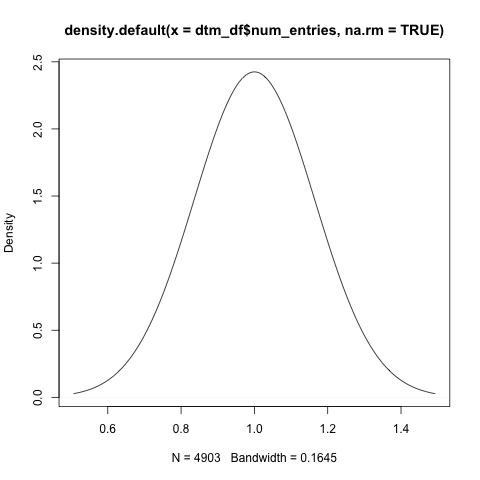

In [37]:
%%R -i dtm_df

dtm_df$num_entries = rowSums(dtm_df)
dtm_df["num_occurances",] = colSums(dtm_df)
dtm_df["num_occurances","num_entries"] = NA 

plot(density(dtm_df$num_entries, na.rm = TRUE))
table(dtm_df$num_entries) #number of documents with each number of entries

#length(which(dtm_df$num_entries >= 10))
#length(which(dtm_df$num_entries >= 100))

There are a few entries which are very common, including one (ŋešnimbar.palm.n) which appears in almost all of the documents. But most, as expected, are very rare, with 75% appearing in 3 or fewer documents.

In [38]:
## Some exploratory analysis
## Note that some entries DO appear more than once in a single document,
## (eg. dcclt/P370399 ŋešnimbar.palm.n)
## Talk with Niek: These multiple entries represent instances where 
## there was a preceeding/succeeding word attached which is not preserved.
## Need to re-figure out how to scrape data.
## so we need to convert dtm_df to presence/absence for the following to work.
## http://oracc.museum.upenn.edu/dcclt/P370399

## Also need to preserve non-lematized information 
## (eg. oiii13-17 http://oracc.museum.upenn.edu/dcclt/P370399)

## There are also lines which are completely unlematized. 
## How do we deal with "traces of" lines? Not consistently noted. Sometimes unknown.
## Line numbers are preserved - add line numbers to data structure
## Last line missing from at least some documents in scraped data

In [39]:
%%R 

# currently "variables" (entries) are sorted alphabetically, would like sorted by frequency
dtm_df = as.matrix((dtm_df > 0) + 0)
dtm_df = dtm_df[,order(colSums(dtm_df), decreasing = TRUE)]
dtm_df = as.data.frame(dtm_df)
dtm_df$document = row.names(dtm_df)

In [40]:
%%R
#install.packages("reshape")
library(reshape)
melted_dtm_df = melt(dtm_df)
head(melted_dtm_df)


Error in library(reshape) : there is no package called ‘reshape’


//anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Error in library(reshape) : there is no package called ‘reshape’

  warnings.warn(x, RRuntimeWarning)


In [41]:
%%R 
# http://stackoverflow.com/questions/10397183/heat-map-of-binary-data-using-r-or-python
#install.packages("ggplot2")
library(ggplot2)
# ggplot(data = melted_dtm_df[150000:160474,], aes(y=document, x=variable, fill=value)) + 
#   geom_tile() +
#   theme(axis.text.x = element_text(angle = 90, hjust = 1, size = 5))

qplot(data=melted_dtm_df, x=variable,y=document, fill=factor(value),
    geom="tile")+scale_fill_manual(values=c("0"="lightblue", "1"="red")) +
  theme(axis.text.x = element_text(angle = 90, hjust = 1, size = 1), axis.text.y = element_text(size = 3))



Error in ggplot(data, aesthetics, environment = env) : 
  object 'melted_dtm_df' not found


//anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Error in ggplot(data, aesthetics, environment = env) : 
  object 'melted_dtm_df' not found

  warnings.warn(x, RRuntimeWarning)


# Cosine Similarity/Distance
Cosine similarity ignores the length of the vector. Cosine distance equals 1 - cosine similarity.

Since many of these texts are very short, they have no overlap and thus a cosine distance of 1.

In [42]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(dtm)
dist_df = pd.DataFrame(np.round(dist, 2), index=dtm_df.index.values, columns=dtm_df.index.values)
dist_df.head()

,0,1,2,3,4,5,6,7,8,9,...,4893,4894,4895,4896,4897,4898,4899,4900,4901,4902
0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import MDS

In [ ]:
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
pos = mds.fit_transform(dist)
names = dist_df.index.values
xs, ys = pos[:, 0], pos[:, 1]


In [ ]:
for x, y, name in zip(xs, ys, names):
    color = 'orange' if "Q" in name else 'skyblue'
    plt.scatter(x, y, c=color)
    plt.text(x, y, name[6:])

In [ ]:
plt.show()

In [ ]:
id_text = dist_df.index.values
text_name = [id_names_equiv_df.ix[textid]['text_name'] for textid in id_text]
provenance = [id_names_equiv_df.ix[textid]['provenance'] for textid in id_text]
colormap = {'Nippur': "blue", 'Ur': "green", 'Isin': "purple", 
          'Uruk': "red", 'unprovenanced': "black"}
colors = [colormap[p] for p in provenance]

In [ ]:
from bokeh.models import ColumnDataSource, OpenURL, TapTool, HoverTool
from bokeh.plotting import figure, output_file, output_notebook, show

output_notebook()

p = figure(
    plot_width=800, plot_height=800,
    tools="tap,pan,wheel_zoom,box_zoom,reset,save", 
    title="Multi Dimensional Scaling of OB lists of wood; based on Cosine Distance. Size of dot = length of document")
p.add_tools(HoverTool(
        tooltips=[
            ("url", "http://oracc.org/" + "@id_text"),
            ("text name", "@text_name"),
            ("provenance", "@provenance")
        ]
        ))

source = ColumnDataSource(data=dict(
        x=xs,
        y=ys,
        id_text=list(dist_df.index.values),
        size = df_length/max(df_length)*50,
        text_name = text_name,
        provenance = provenance,
        colors = colors
    ))

p.circle('x', 'y', color='colors', size='size', source=source)

url = "http://oracc.museum.upenn.edu/@id_text"
    

taptool = p.select(type=TapTool)
taptool.callback = OpenURL(url=url)

show(p)

# Discussion
The above visualization is not very satisfactory. It is based *only* on shared entries. Large texts (large circles) group together because they have a larger number of shared entries.

Commonalities between texts that have been identified by hand (e.g. the green dots, provenance Ur or the purple dots, provenance Isin) are not refelcted in the graph.

Many of the dots are so small that they are currently invisible. A graph that does not size the dots according to text length shows an even distribution of the dots over the space.